In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import snntorch.surrogate as surrogate

import os
import yaml
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from scipy.ndimage import gaussian_filter1d

from dataloader import train_test_val_split, get_dataset_statistics
from models import SpikingNetwork, TwoLayerSNN, ThreeLayerSNN
from utils.encoding import Rate_Encoder, Current_Encoder

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
seed = 0
device = 'cpu'
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [59]:
def get_model_and_dataset(train_config):
    # read in the paths to where to read from/to data
    with open('configs/paths.yaml', 'r') as file:
        path_configs = yaml.safe_load(file)

    # read in the instructions for how to train model
    with open(f'configs/model_configs/{train_config}', 'r') as file:
        train_configs = yaml.safe_load(file)

    # --- Create Datasets/DataLoaders --- #    
    binary = train_configs['binary']

    dataset_configs = {
        "data_file": os.path.join(path_configs['data_folder'], train_configs['dataset'], f"{train_configs['dataset']}.hdf5"),
        "metadata":  os.path.join(path_configs['data_folder'], train_configs['dataset'], f"{train_configs['dataset']}.csv"),
        "binary": binary,
        "random_state": 0,
        **train_configs['dataset_configs']
    }

    logging_configs={
        'model_name': train_configs['model_name'],
        'weight_folder': path_configs['weight_folder'],
        'log_folder': path_configs['log_folder'],
        'log_steps': train_configs['log_steps']
    }

    eval_batch_size = train_configs['eval_batch_size']

    train_dataset, _, test_dataset = train_test_val_split(**dataset_configs)
    train_mean, train_std = get_dataset_statistics(train_dataset)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size)

        # --- Model Configs --- #
    model_configs = train_configs['model_configs']
    if model_configs['neuron_options']['spike_grad'] == 'atan':
        model_configs['neuron_options']['spike_grad'] = surrogate.atan(alpha=2)

    if train_configs['model_class'] == 'TwoLayerSNN':
        model = TwoLayerSNN(**model_configs)
    else:
        model = SpikingNetwork(**model_configs)

    if train_configs['encoder'] == 'rate':
        encoder = Rate_Encoder(**train_configs['encoder_args'])
    else:
        encoder = Current_Encoder(train_mean, train_std)

    model_path = os.path.join(logging_configs['weight_folder'], logging_configs['model_name']) + '.pth'
    checkpoint = torch.load(model_path, weights_only=False)
    model.load_state_dict(checkpoint['model'])

    threshold = None
    if binary:
        threshold = checkpoint['threshold']

    return model, test_loader, encoder, threshold


In [60]:
def get_binary_metrics(model, test_loader, encoder, threshold, perturb, device='cpu'):
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for data, target in test_loader:

            if encoder is not None:
                data = encoder.encode(data)

            data, target = data.to(device), target.to(device)
            data = perturb(data)

            output = model(data).squeeze(1)
    
            y_true.append(target.numpy())
            y_pred.append(output.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    auc = roc_auc_score(y_true, y_pred)

    y_pred = (y_pred  > threshold).astype(int)
    
    accuracy = (y_true == y_pred).mean()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel().tolist()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    ppv = tp / (tp + fp + 1e-8)
    npv = tn / (tn + fn + 1e-8)

    return auc, accuracy, sensitivity, specificity, ppv, npv

# Generate ROC and CM Plots

In [61]:
def get_roc_curve(model, test_loader, encoder, threshold, device='cpu'):
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for data, target in test_loader:

            if encoder is not None:
                data = encoder.encode(data)

            data, target = data.to(device), target.to(device)

            output = model(data).squeeze(1)
    
            y_true.append(target.numpy())
            y_pred.append(output.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    auc = roc_auc_score(y_true, y_pred)

    y_pred = (y_pred > threshold).astype(int)
    
    cm = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel().tolist()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    ppv = tp / (tp + fp + 1e-8)
    npv = tn / (tn + fn + 1e-8)

    acc = (y_true == y_pred).astype(int).mean()

    return {
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'cm': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'acc': acc,
        
    }

## Supervised

In [62]:
model, test_loader, encoder, threshold = get_model_and_dataset('binary_rate_encoding.yaml')

rate_results = get_roc_curve(model, test_loader, encoder, threshold)

print('Rate-Encoding')
print('acc: {}'.format(rate_results['acc']))
print('sensitivity: {}'.format(rate_results['sensitivity']))
print('specificity: {}\n'.format(rate_results['specificity']))


model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')

current_results = get_roc_curve(model, test_loader, encoder, threshold)

print('Current-Encoding')
print('acc: {}'.format(current_results['acc']))
print('sensitivity: {}'.format(current_results['sensitivity']))
print('specificity: {}\n'.format(current_results['specificity']))


Rate-Encoding
acc: 0.825157441166722
sensitivity: 0.8298755186672799
specificity: 0.8233264320201902

Current-Encoding
acc: 0.8641034139874048
sensitivity: 0.8612922347311127
specificity: 0.8651943869315271



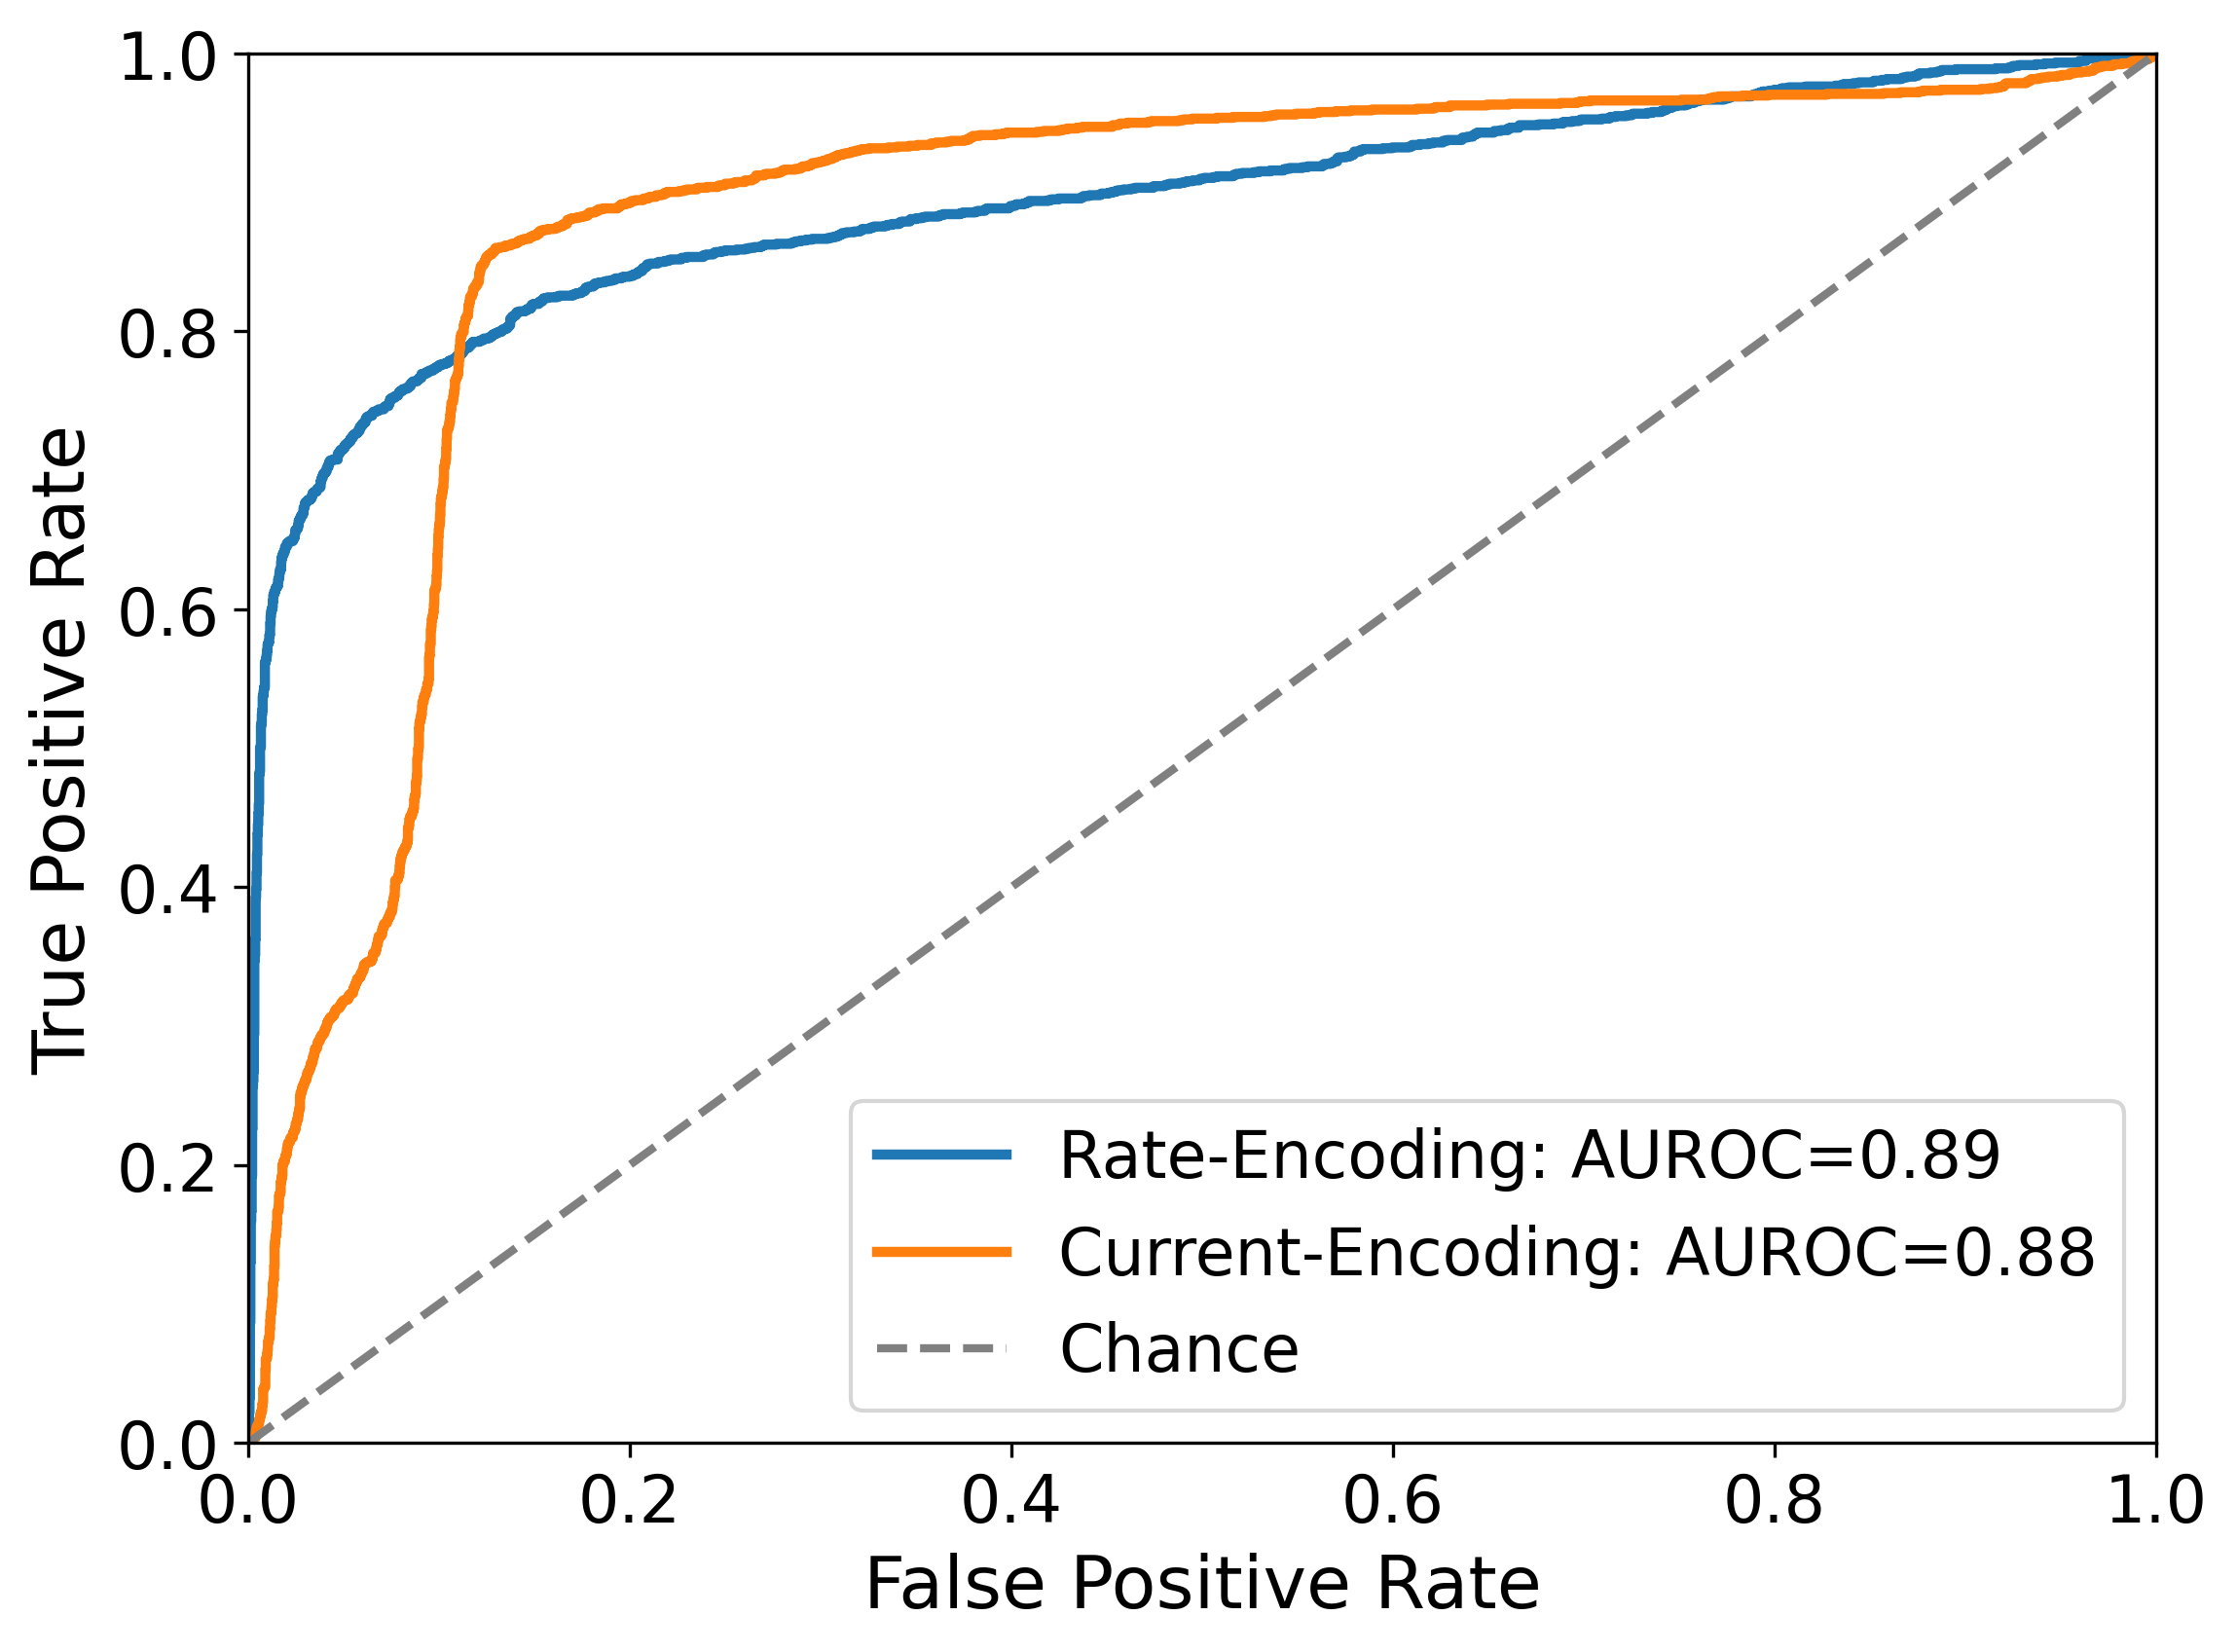

In [63]:
plt.rcParams.update({
    "font.size": 18,          # main text size
    "axes.titlesize": 20,     # axes title
    "axes.labelsize": 18,     # x/y labels
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)

# ------------------------
# ROC curves (thicker lines)
# ------------------------
ax.plot(rate_results['fpr'], rate_results['tpr'],
        label=f"Rate-Encoding: AUROC={rate_results['auc']:.2f}",
        linewidth=2.5)

ax.plot(current_results['fpr'], current_results['tpr'],
        label=f"Current-Encoding: AUROC={current_results['auc']:.2f}",
        linewidth=2.5)

ax.plot([0, 1], [0, 1],
        '--', color='gray', linewidth=2,
        label='Chance')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.legend()

plt.tight_layout()
plt.savefig('../figures/roc_base', bbox_inches='tight')
plt.show()

## Unsupervised

In [69]:
model, test_loader, encoder, threshold = get_model_and_dataset('finetuned_rand_binary_rate_encoding.yaml')

rate_results = get_roc_curve(model, test_loader, encoder, threshold)

print('Random')
print('acc: {}'.format(rate_results['acc']))
print('sensitivity: {}'.format(rate_results['sensitivity']))
print('specificity: {}\n'.format(rate_results['specificity']))


model, test_loader, encoder, threshold = get_model_and_dataset('finetuned_heb_binary_rate_encoding.yaml')

current_results = get_roc_curve(model, test_loader, encoder, threshold)

print('Hebb')
print('acc: {}'.format(current_results['acc']))
print('sensitivity: {}'.format(current_results['sensitivity']))
print('specificity: {}\n'.format(current_results['specificity']))

model, test_loader, encoder, threshold = get_model_and_dataset('finetuned_oja_binary_rate_encoding.yaml')

current_results = get_roc_curve(model, test_loader, encoder, threshold)

print('Oja')
print('acc: {}'.format(current_results['acc']))
print('sensitivity: {}'.format(current_results['sensitivity']))
print('specificity: {}\n'.format(current_results['specificity']))

model, test_loader, encoder, threshold = get_model_and_dataset('finetuned_sanger_binary_rate_encoding.yaml')

current_results = get_roc_curve(model, test_loader, encoder, threshold)

print('Sanger')
print('acc: {}'.format(current_results['acc']))
print('sensitivity: {}'.format(current_results['sensitivity']))
print('specificity: {}\n'.format(current_results['specificity']))



Random
acc: 0.532151143520053
sensitivity: 0.47006520450225214
specificity: 0.5562456866791897

Hebb
acc: 0.7204176334106729
sensitivity: 0.0
specificity: 0.9999999999976996

Oja
acc: 0.7121312562147829
sensitivity: 0.03675163011240811
specificity: 0.9742351046676462

Sanger
acc: 0.7741133576400397
sensitivity: 0.7368109069310207
specificity: 0.7885898320662789



# Evaluate How Robust Different Models are to Varying Degrees of Noise or Input Perturbation

## Perturbation Functions

In [78]:
class RandomShift:
    def __init__(self, shift_range):
        self.shift_range = shift_range
    
    def __call__(self, x):
        # randomly shift an input torch tensor of size [B x N x D]. fill in new values with zeros
        # random translation is uniform within +- shift_range

        out = torch.zeros_like(x)
        shift = random.choice((-self.shift_range, self.shift_range))

        if shift > 0:
            out[:, shift:] = x[:, :-shift]
        elif shift < 0:
            out[:, :shift] = x[:, -shift:]
        else:
            return x.clone()
        
        return out

class GaussianNoise:
    def __init__(self, std):
        self.std = std
    
    def __call__(self, x):
        # add 0-centered random gaussian noise to an input tensor of arbitary size
        noise = torch.randn_like(x) * self.std
        return x + noise

## Perturb Inputs and See How Models Perform

### Random Shift

In [79]:
shift_ranges = np.arange(start=0, stop=33, step=3)
shift_ranges

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30])

In [80]:
print('Evaluating Rate Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_rate_encoding.yaml')
rate_coding_results_shift = []

for shift_range in tqdm(shift_ranges):
    perturb = RandomShift(shift_range)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    rate_coding_results_shift.append((shift_range, model_metrics))
    

print('Evaluating Current Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')
current_coding_results_shift = []

for shift_range in tqdm(shift_ranges):
    perturb = RandomShift(shift_range)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    current_coding_results_shift.append((shift_range, model_metrics))

Evaluating Rate Coding Model


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Evaluating Current Coding Model


100%|██████████| 11/11 [00:24<00:00,  2.25s/it]


### Random Noise

In [81]:
noise_stds = np.linspace(start=0, stop=3.0, num=10)
noise_stds

array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ])

In [82]:
print('Evaluating Rate Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_rate_encoding.yaml')
rate_coding_results_noise = []

for noise_std in tqdm(noise_stds):
    perturb = GaussianNoise(noise_std)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    rate_coding_results_noise.append((noise_std, model_metrics))
    

print('Evaluating Current Coding Model')
model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')
current_coding_results_noise = []

for noise_std in tqdm(noise_stds):
    perturb = GaussianNoise(noise_std)
    model_metrics = get_binary_metrics(model, test_loader, encoder, threshold, perturb, device)
    current_coding_results_noise.append((noise_std, model_metrics))

Evaluating Rate Coding Model


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Evaluating Current Coding Model


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


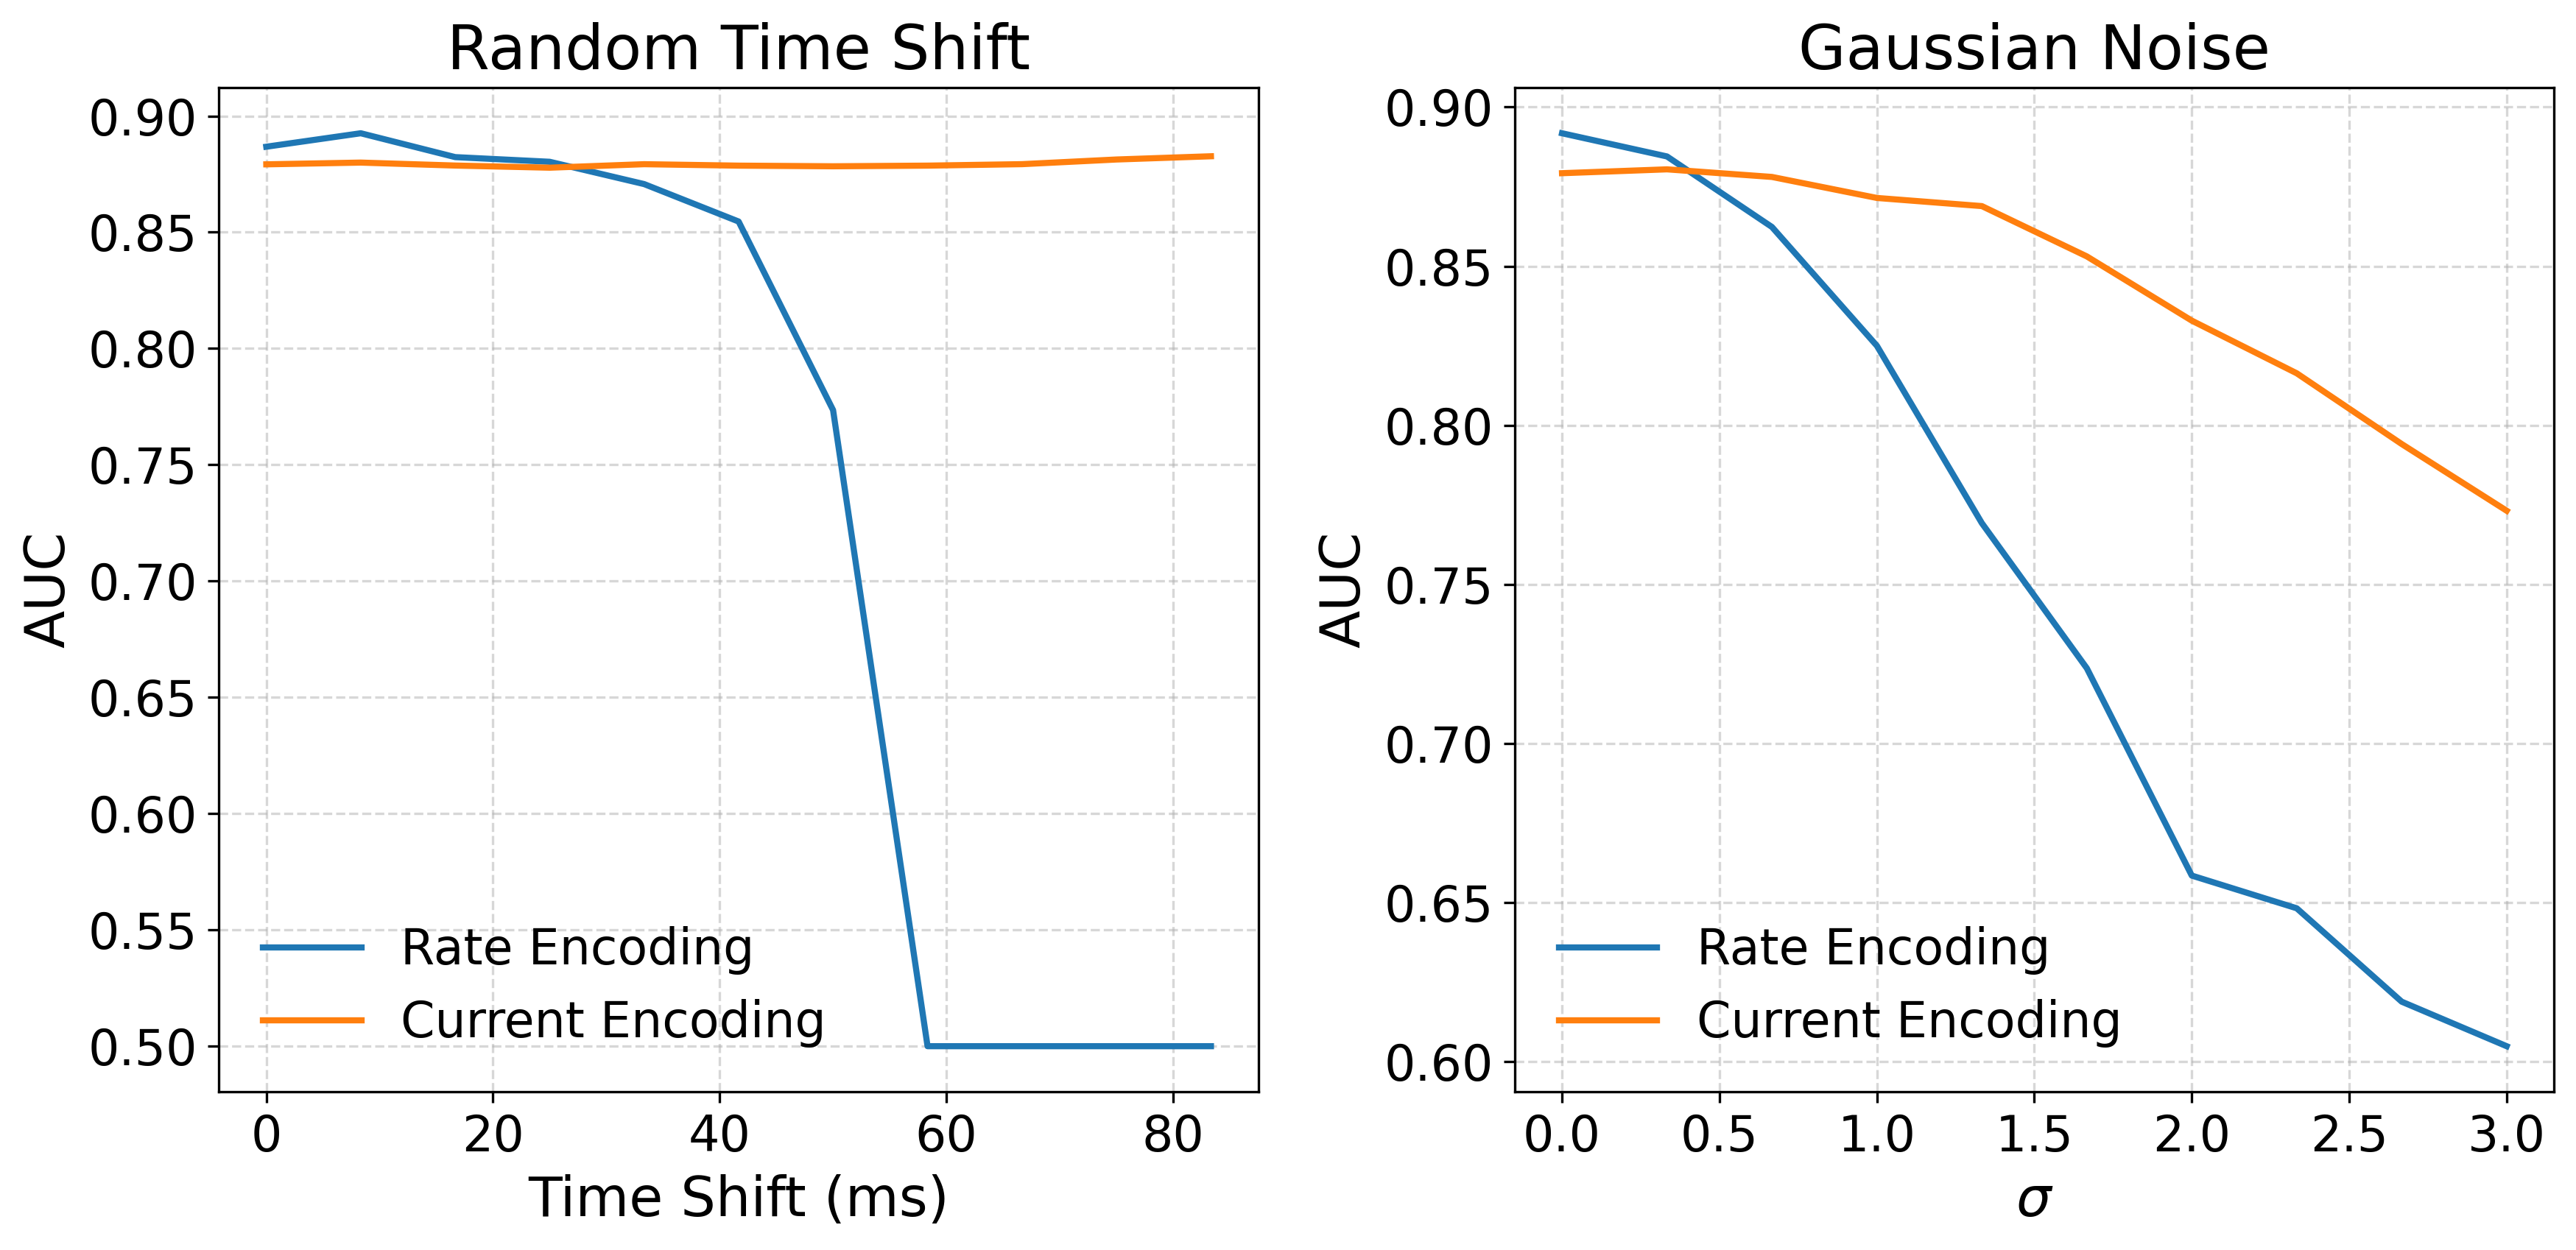

In [91]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
})

# ----------------------------------------------------
# Extract shift results
# ----------------------------------------------------
shifts, rate_metrics_shift = zip(*rate_coding_results_shift)
rate_aucs_shift = [rm[0] for rm in rate_metrics_shift]

shifts, current_metrics_shift = zip(*current_coding_results_shift)
current_aucs_shift = [rm[0] for rm in current_metrics_shift]

# Convert shift index -> ms
shifts = np.array(shifts) * 1000 / 360

# ----------------------------------------------------
# Extract noise results
# ----------------------------------------------------
stds, rate_metrics_noise = zip(*rate_coding_results_noise)
rate_aucs_noise = [rm[0] for rm in rate_metrics_noise]

stds, current_metrics_noise = zip(*current_coding_results_noise)
current_aucs_noise = [rm[0] for rm in current_metrics_noise]

stds = np.array(stds)

# ----------------------------------------------------
# Make combined plot (2 subplots)
# ----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# ----------------------------------------------------
# Left: Time shift robustness
# ----------------------------------------------------
ax = axes[0]
ax.plot(shifts, rate_aucs_shift, label='Rate Encoding', linewidth=2)
ax.plot(shifts, current_aucs_shift, label='Current Encoding', linewidth=2)

ax.set_xlabel('Time Shift (ms)')
ax.set_ylabel('AUC')
ax.set_title('Random Time Shift')
ax.legend(frameon=False, loc='lower left')
ax.grid(True, linestyle='--', alpha=0.5)

# ----------------------------------------------------
# Right: Noise robustness
# ----------------------------------------------------
ax = axes[1]
ax.plot(stds, rate_aucs_noise, label='Rate Encoding', linewidth=2)
ax.plot(stds, current_aucs_noise, label='Current Encoding', linewidth=2)

ax.set_xlabel('$\sigma$')
ax.set_ylabel('AUC')
ax.set_title('Gaussian Noise')
ax.legend(frameon=False)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/robustness.png');

# Visualize Spiking Activity With a Current-Encoding Network

In [13]:
def infer(model, encoder, data):
    # run a model for a single example
    data = encoder.encode(data).unsqueeze(0)
    output, z0, z1 = model(data)
    return output.squeeze(), z0, z1

In [14]:
model, test_loader, encoder, threshold = get_model_and_dataset('binary_current_encoding.yaml')
model.logging_mode = True
test_dataset = test_loader.dataset

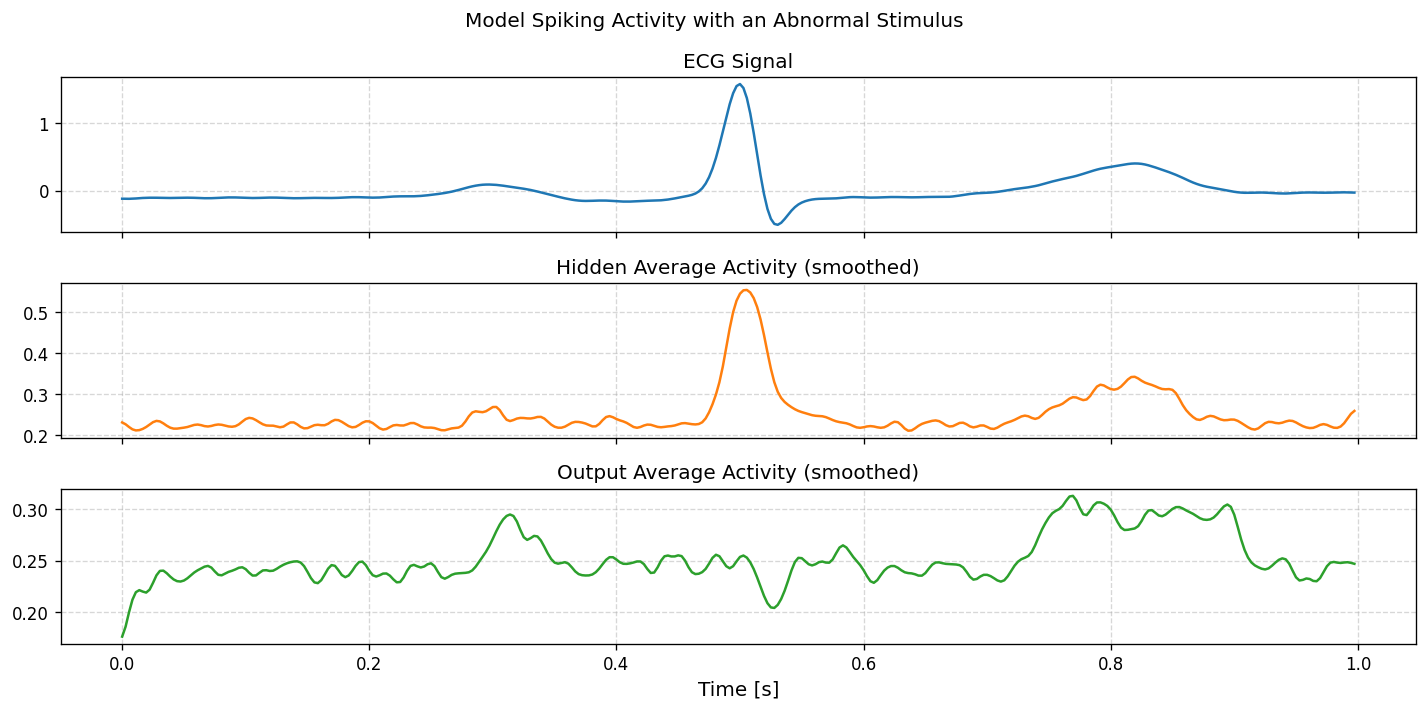

In [15]:
# 4, 120: good abnormal
# 5: good normal
x, label = test_dataset[5]
y_raw, z0, z1 = infer(model, encoder, x)

z0_avg = z0.squeeze().mean(1)
z1_avg = z1.squeeze().mean(1)

y = int(y_raw > threshold)

time = np.arange(len(x)) / 360

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, dpi=120)

fig.suptitle('Model Spiking Activity with an Abnormal Stimulus')

axes[0].plot(time, x, color='C0')
axes[0].set_title('ECG Signal', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(time, gaussian_filter1d(z0_avg, 2), color='C1')
axes[1].set_title('Hidden Average Activity (smoothed)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].plot(time, gaussian_filter1d(z1_avg, 2), color='C2')
axes[2].set_title('Output Average Activity (smoothed)', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

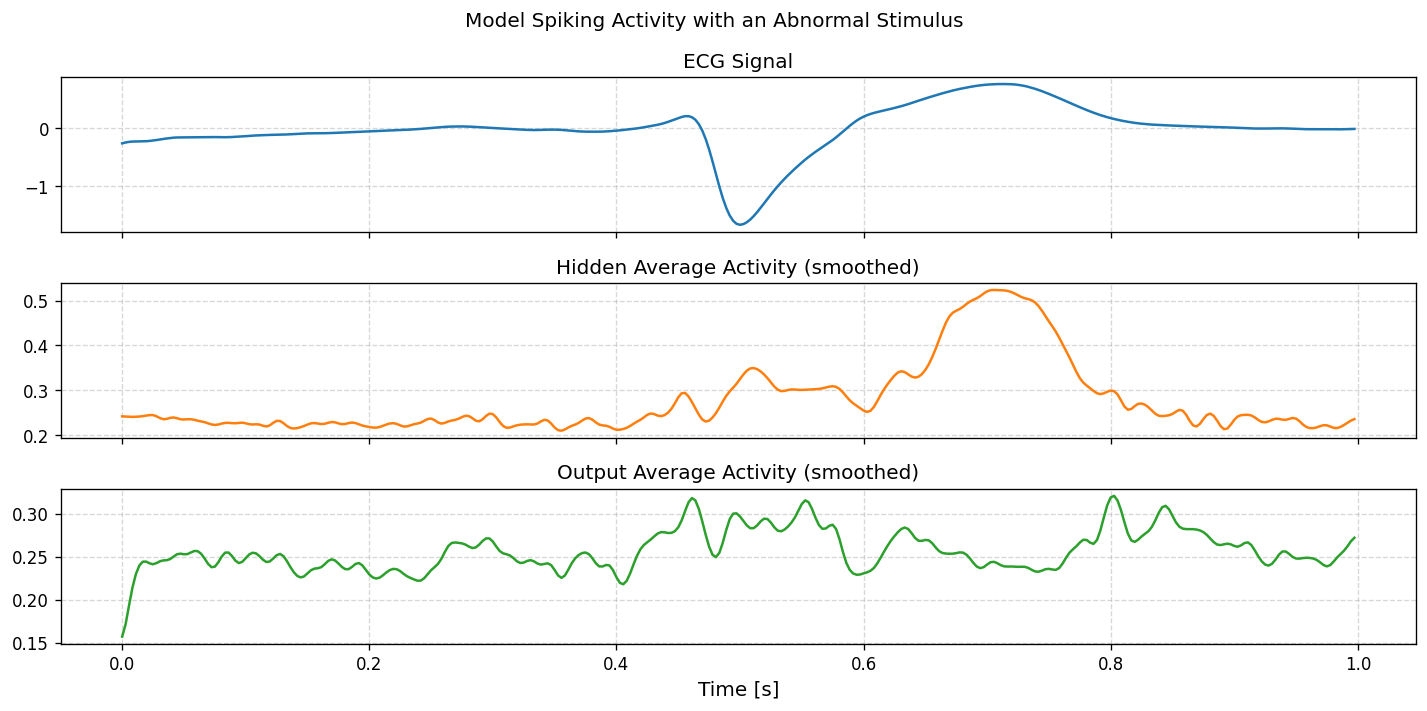

In [16]:
# 4, 120: good abnormal
# 5: good normal
x, label = test_dataset[120]
y_raw, z0, z1 = infer(model, encoder, x)

z0_avg = z0.squeeze().mean(1)
z1_avg = z1.squeeze().mean(1)

y = int(y_raw > threshold)

time = np.arange(len(x)) / 360

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True, dpi=120)

fig.suptitle('Model Spiking Activity with an Abnormal Stimulus')

axes[0].plot(time, x, color='C0')
axes[0].set_title('ECG Signal', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(time, gaussian_filter1d(z0_avg, 2), color='C1')
axes[1].set_title('Hidden Average Activity (smoothed)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].plot(time, gaussian_filter1d(z1_avg, 2), color='C2')
axes[2].set_title('Output Average Activity (smoothed)', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

In [33]:
labels = []
outputs = []
z0s = []
z1s = []

for data, target in tqdm(test_loader):
    with torch.no_grad():
        data = encoder.encode(data)
        data, target = data.to(device), target.to(device)
        output, z0, z1 = model(data)
        z0 = z0.transpose(0, 1)
        z1 = z1.transpose(0, 1)
    
    labels.append(target.numpy())
    outputs.append(output.numpy())
    z0s.append(z0.numpy())
    z1s.append(z1.numpy())

labels = np.concatenate(labels)
z0s = np.concatenate(z0s)
z1s = np.concatenate(z1s)

100%|██████████| 48/48 [00:02<00:00, 17.88it/s]


In [38]:
neg_mask = np.where(labels == 0)
pos_mask = np.where(labels == 1)

neg_labels = labels[neg_mask]
pos_labels = labels[pos_mask]

neg_z0s = z0s[neg_mask]
pos_z0s = z0s[pos_mask]

neg_z1s = z1s[neg_mask]
pos_z1s = z1s[pos_mask]

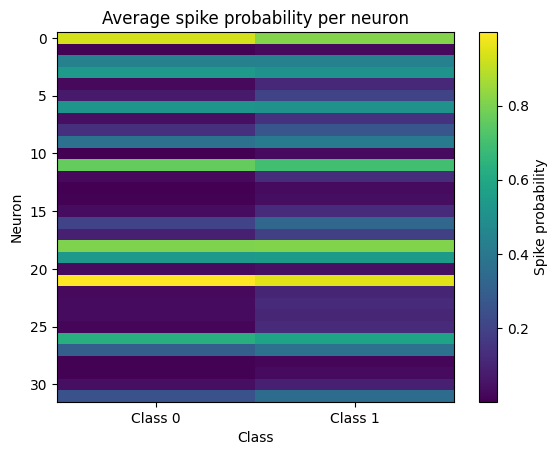

In [54]:
neg_z0_rates = neg_z0s.mean((0, 1))
pos_z0_rates = pos_z0s.mean((0, 1))

avg_spike_matrix = np.stack([neg_z0_rates, pos_z0_rates], 1)

plt.imshow(avg_spike_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Spike probability')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Neuron')
plt.title('Average spike probability per neuron')
plt.show()


Most class-selective neurons: [26 31 63 22 19 48 62 54 36 58]


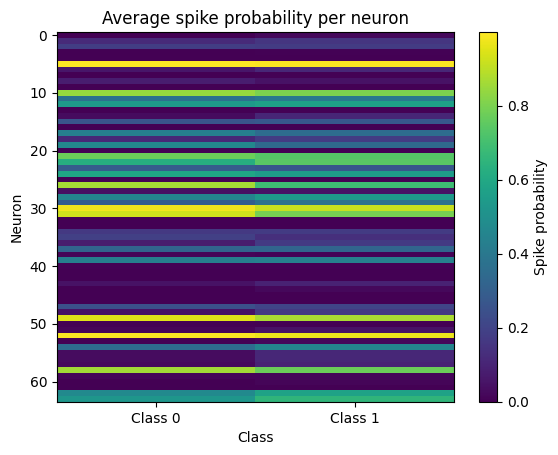

In [57]:
neg_z1_rates = neg_z1s.mean((0, 1))
pos_z1_rates = pos_z1s.mean((0, 1))

avg_spike_matrix = np.stack([neg_z1_rates, pos_z1_rates], 1)

diff = np.abs(pos_z1_rates - neg_z1_rates)
selective_neurons = np.argsort(diff)[-10:][::-1]
print("Most class-selective neurons:", selective_neurons)


plt.imshow(avg_spike_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Spike probability')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Neuron')
plt.title('Average spike probability per neuron')
plt.show()


In [65]:
# Check Hebbian Learning Selectivity
model, test_loader, encoder, threshold = get_model_and_dataset('pretrained_binary_rate_encoding.yaml')

model.logging_mode = True

In [66]:
labels = []
outputs = []
z0s = []
z1s = []

for data, target in tqdm(test_loader):
    with torch.no_grad():
        data = encoder.encode(data)
        data, target = data.to(device), target.to(device)
        output, z0, z1 = model(data)
        z0 = z0.transpose(0, 1)
        z1 = z1.transpose(0, 1)
    
    labels.append(target.numpy())
    outputs.append(output.numpy())
    z0s.append(z0.numpy())
    z1s.append(z1.numpy())

labels = np.concatenate(labels)
z0s = np.concatenate(z0s)
z1s = np.concatenate(z1s)

100%|██████████| 48/48 [00:00<00:00, 80.97it/s]


In [67]:
neg_mask = np.where(labels == 0)
pos_mask = np.where(labels == 1)

neg_labels = labels[neg_mask]
pos_labels = labels[pos_mask]

neg_z0s = z0s[neg_mask]
pos_z0s = z0s[pos_mask]

neg_z1s = z1s[neg_mask]
pos_z1s = z1s[pos_mask]

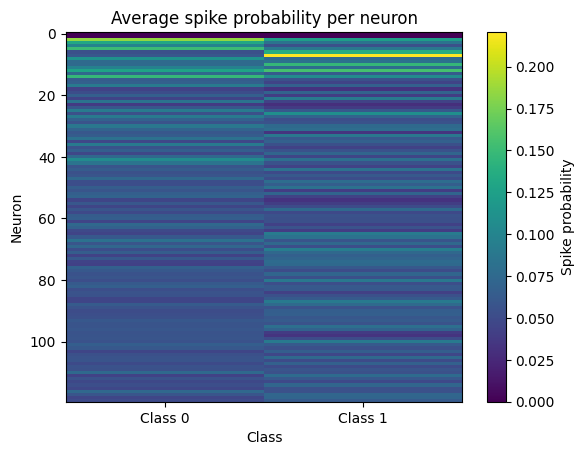

In [68]:
neg_z0_rates = neg_z0s.mean((0, 1))
pos_z0_rates = pos_z0s.mean((0, 1))

avg_spike_matrix = np.stack([neg_z0_rates, pos_z0_rates], 1)

plt.imshow(avg_spike_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Spike probability')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Neuron')
plt.title('Average spike probability per neuron')
plt.show()

Most class-selective neurons: [22 29 24 23 20 17 12 56  8 18]


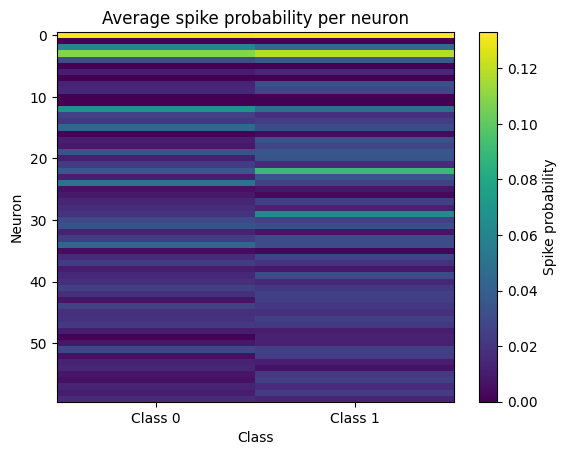

In [69]:
neg_z1_rates = neg_z1s.mean((0, 1))
pos_z1_rates = pos_z1s.mean((0, 1))

avg_spike_matrix = np.stack([neg_z1_rates, pos_z1_rates], 1)

diff = np.abs(pos_z1_rates - neg_z1_rates)
selective_neurons = np.argsort(diff)[-10:][::-1]
print("Most class-selective neurons:", selective_neurons)


plt.imshow(avg_spike_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Spike probability')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Class')
plt.ylabel('Neuron')
plt.title('Average spike probability per neuron')
plt.show()